# Render Contours

author = Caroline Magg <br>
date = 01 April 2020 <br>

___________________________________
history: <br>
2020-04-12 <br>
build PatientData wrapper with convient methods for data processing <br>
2020-04-05 <br>
refactor PatientData to have object for PatientData (contour, pre and post treatment) and DicomFileWrapper <br>
first tests with active contour methods form skikit-image <br>

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pydicom
from natsort import natsorted

### Add dependencies

In [2]:
# add KidsBrainProject main folder to paths
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../utils/'))

In [3]:
#from utils_explore import read_structure,read_contour,read_contour_names,read_contour_row
from PatientData import PatientData
from DicomWrapper import DicomWrapper

In [4]:
# add path to data here
path_data = "../../Data/" 

In [5]:
idx = 1
folder_name = os.path.join(path_data, str(idx))
folder = os.listdir(folder_name)
folder

['CT',
 'RD.Jacks1IMPT.dcm',
 'RD.Jacks1IMPTb.dcm',
 'RS.Jacks1.dcm',
 'T1 +C 3-15-16',
 'T1 +C 3-23-16',
 'T1 +C 4-29-16',
 'T2 CISS 3-15-16',
 'T2 CUBE 4-29-16']

In [6]:
contours_list = pd.read_csv("list_contours.csv",delimiter=';')
contours_list

,Number,RoiName
0,1,Brain
1,2,Cerebel
2,3,Cingulum
3,4,Corpus callosum
4,5,CTV
5,6,Entorhinal
6,7,Fornix
7,8,FrontalLobe
8,9,GTV
9,10,Hippocampus


In [7]:
contour_of_interest = ["PTV","GTV","CTV"]

# PatientData

In [8]:
files = os.listdir(os.path.join(path_data, str(idx)))
path_contour = os.path.join(path_data, str(idx), 'RS.Jacks1.dcm')
path_preop = os.path.join(path_data, str(idx), 'CT')
path_postop1 = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x]]
dcm = pydicom.dcmread(path_contour)
path_contour, path_preop, path_postop1

('../../Data/1\\RS.Jacks1.dcm',
 '../../Data/1\\CT',
 ['../../Data/1\\T1 +C 3-15-16',
  '../../Data/1\\T1 +C 3-23-16',
  '../../Data/1\\T1 +C 4-29-16'])

In [9]:
data = PatientData(path_preop, path_postop1, path_contour)


Preop dicom
Image size.......: (512, 512, 292)
Pixel spacing....: (0.9765625, 0.9765625, 1.0)
Slices number....: 292
Slices location...: 346.5  -  55.5
Position.........: (-250.0, -217.0, 346.5)
Resulting correction: [251.0, 218.0, 0]

Postop ../../Data/1\T1 +C 3-15-16
Image size.......: (512, 512, 292)
Pixel spacing....: (0.9765625, 0.9765625, 1.0)
Slices number....: 292
Slices location...: 346.5  -  55.5
Position.........: (-250.0, -217.0, 346.5)
Resulting correction: [251.0, 218.0, 0]

Postop ../../Data/1\T1 +C 3-23-16
Image size.......: (512, 512, 292)
Pixel spacing....: (0.9765625, 0.9765625, 1.0)
Slices number....: 292
Slices location...: 346.5  -  55.5
Position.........: (-250.0, -217.0, 346.5)
Resulting correction: [251.0, 218.0, 0]

Postop ../../Data/1\T1 +C 4-29-16
Image size.......: (512, 512, 292)
Pixel spacing....: (0.9765625, 0.9765625, 1.0)
Slices number....: 292
Slices location...: 346.5  -  55.5
Position.........: (-250.0, -217.0, 346.5)
Resulting correction: [251.0, 

In [10]:
struct = "Brain"
data.filter_contour_list(roiname=[struct, 'PTV1'],mode="exact")

,ID,RoiNumber,RoiName
1,1,1,Brain
30,30,38,PTV1


In [11]:
data.read_filtered_contour()

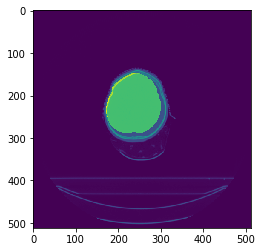

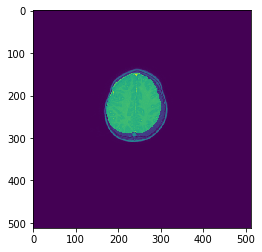

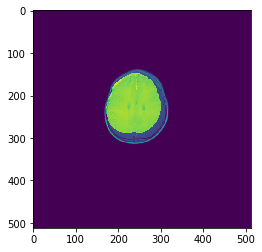

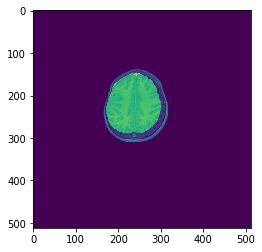

In [12]:
# visualise segmentation in 2D
ind = 65
data.show_overlays(ind,struct)

In [13]:
#TODO: show 3D model with VTK

# Segmentation

In [14]:
import skimage.segmentation as segmentation
snake_init = data.get_contour(ind,struct)

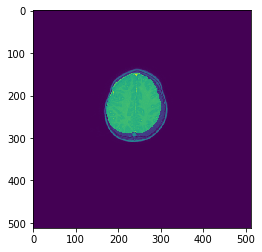

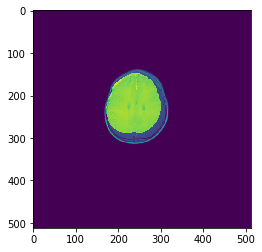

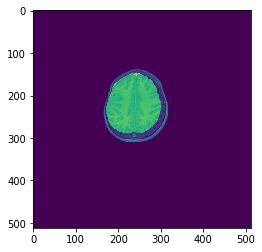

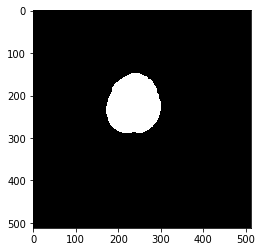

In [16]:
# initial status
ind = 65
struct = "Brain"
img_postop = data.get_post_images(ind)
pts_init = data.get_contour(ind,struct)
contour_init = data.create_contour_overlay(ind,struct)
data.show_overlay_post(ind,struct)
plt.imshow(contour_init,cmap='gray')

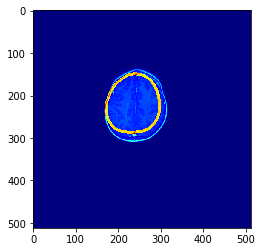

In [18]:
# active contours for first image without dilation - just testing if working->will not create better segmentation since not larger
image = img_postop[0]
segm = segmentation.active_contour(image, pts_init)

contour_img = np.zeros_like(image)
vertices = segm.astype(np.int32)
if len(vertices) != 0:
    cv2.drawContours(contour_img, [vertices], -1, (255,0,0), 5)
    #cv2.drawContours(contour_img, [snake_init], -1, (255,0,0), 3)
overlay_post = cv2.addWeighted(image.astype(np.int16), 1.0, contour_img, 1.0, 0)
plt.imshow(overlay_post, cmap='jet')
plt.show()

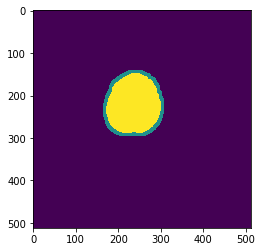

In [41]:
# dilate 
kernel = np.ones((15,15),np.uint8)
contour_dilated = cv2.dilate(contour_init,kernel,iterations = 1)
toshow = contour_init+contour_dilated
plt.imshow(toshow)
plt.show()
tmp = cv2.findContours(contour_dilated.astype(np.uint8),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
pts_dilated = tmp[1][0]

In [45]:
np.shape(pts_init), np.shape(pts_dilated)

((278, 2), (210, 1, 2))

In [47]:
pts_dilated.shape

(210, 1, 2)

array([[235, 140],
       [234, 141],
       [224, 141],
       [223, 142],
       [222, 142],
       [220, 144],
       [219, 144],
       [218, 145],
       [217, 145],
       [216, 146],
       [214, 146],
       [212, 148],
       [210, 148],
       [208, 150],
       [206, 150],
       [204, 152],
       [203, 152],
       [199, 156],
       [198, 156],
       [196, 158],
       [195, 158],
       [194, 159],
       [193, 159],
       [193, 160],
       [192, 161],
       [191, 161],
       [188, 164],
       [187, 164],
       [184, 167],
       [184, 168],
       [183, 169],
       [183, 170],
       [182, 171],
       [181, 171],
       [181, 172],
       [180, 173],
       [180, 174],
       [179, 175],
       [179, 180],
       [178, 181],
       [178, 184],
       [177, 185],
       [177, 187],
       [176, 188],
       [176, 190],
       [175, 191],
       [174, 191],
       [174, 192],
       [172, 194],
       [172, 197],
       [171, 198],
       [171, 199],
       [170,

In [42]:
# active contours for first image
image = img_postop[0]
segm = segmentation.active_contour(image, pts_dilated)

contour_img = np.zeros_like(image)
vertices = segm.astype(np.int32)
if len(vertices) != 0:
    cv2.drawContours(contour_img, [vertices], -1, 255, -1)
    #cv2.drawContours(contour_img, [snake_init], -1, (255,0,0), 3)
overlay_post = cv2.addWeighted(image.astype(np.int16), 1.0, contour_img, 1, 0)
plt.imshow(overlay_post)
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [92]:
# random walker
segm2 = segmentation.random_walker(image, snake_contour,beta = 3000)

In [93]:
np.shape(segm2), segm2.min(), segm2.max()

((512, 512), 1, 1)

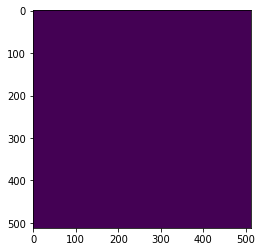

In [94]:
plt.imshow(segm2==1)

In [50]:
contour_img.max()

255

### TMP